In [1]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import json
from signatures.tensor_algebra import TensorAlgebra
from signatures.tensor_sequence import TensorSequence
from models.sig_vol import SigVol
from products.vanilla_option import VanillaOption
from models.model_params import LewisParams

/home/mr_giraffe/anaconda3/lib/python3.8/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
%%time
ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: user 3min 10s, sys: 362 ms, total: 3min 11s
Wall time: 3min 11s


In [3]:
N = 3
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

### Model setup

In [4]:
N = 3
rho = -0.5

model = SigVol(model_type="log-normal", 
               vol_ts=0.2 * Ø + 0.01 * _1 + 0.1 * _2 + 0.05 * _11 + 0.05 * _12 + 0.05 * _22 + 0.01 * _222 + 0.03 * _221 + 0.01 * _121 + 0.01 * _211, 
               ta=ta, 
               sigmas=lambda t: np.ones((len(t), 1)), R=[[1]], rhos=[rho])

In [5]:
ta.print(model.vol_ts)

0.2*∅ + 0.01*1 + 0.1*2 + 0.05*11 + 0.05*12 + 0.05*22 + 0.01*121 + 0.01*211 + 0.03*221 + 0.01*222


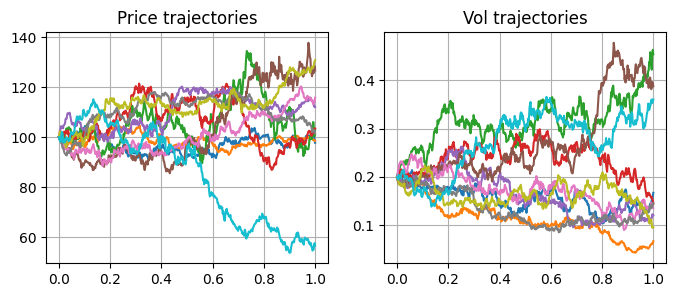

In [6]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

### Define the option 

In [7]:
T = 1
F0 = 100
K = np.array([90, 100, 110])

k = np.log(K / F0)

option = VanillaOption(T=T, K=K, flag="call")

### Pricing

In [8]:
%%time
smile_cf = option.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                            pricing_params=LewisParams(cf_timestep=0.01))

CPU times: user 1min 20s, sys: 260 ms, total: 1min 21s
Wall time: 1min 18s


In [11]:
%%timeit
smile_cf = option.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                            pricing_params=LewisParams(cf_timestep=0.01))

491 ms ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[0.23867271 0.22459828 0.21390662]


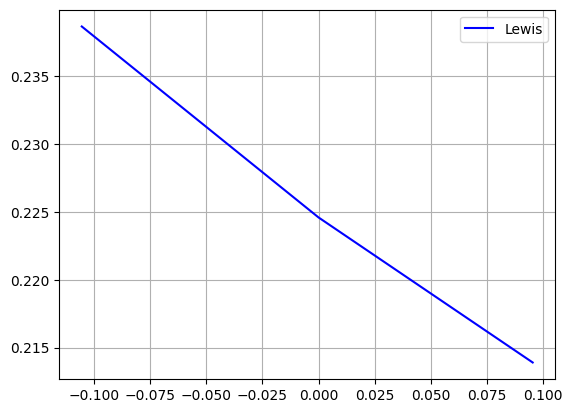

In [12]:
print(smile_cf)

fig, ax = plt.subplots()

ax.plot(np.log(K / F0), smile_cf, "b", label="Lewis")
ax.grid()
ax.legend()